Problem 1

=== Quadratic model sweeps ===

-- lr = 0.1 --
Non-finite loss at epoch 9: inf

-- lr = 0.01 --
Non-finite loss at epoch 15: inf

-- lr = 0.001 --
Non-finite loss at epoch 140: inf

-- lr = 0.0001 --
Epoch  500, Loss 11.628112
Epoch 1000, Loss 9.293488
Epoch 1500, Loss 7.631711
Epoch 2000, Loss 6.448539
Epoch 2500, Loss 5.605815
Epoch 3000, Loss 5.005253
Epoch 3500, Loss 4.576953
Epoch 4000, Loss 4.271185
Epoch 4500, Loss 4.052580
Epoch 5000, Loss 3.895977

Best quadratic:
  lr=0.0001, params=[0.5516595244407654, -0.8505886793136597, -0.8955172896385193], final_loss=3.895977

=== Linear baseline ===
Epoch  500, Loss 7.860120
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647
Final linear: params=[5.367084503173828, -17.301193237304688], loss=2.927647


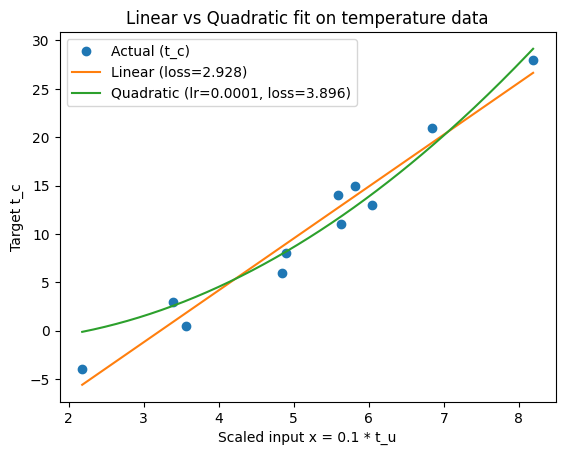


Verdict:
Quadratic model is worse (higher final loss) than the linear baseline.


In [11]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

t_c = torch.tensor([0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0])
t_u = torch.tensor([35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4])
x = 0.1 * t_u

def model_linear(x, w, b):
    return w * x + b

def model_quadratic(x, w2, w1, b):
    return w2 * x**2 + w1 * x + b

def loss_fn(y_hat, y):
    return torch.mean((y_hat - y) ** 2)

def training_loop(n_epochs, optimizer, params, x, y, fwd_fn, log_every=500):
    history = []
    for epoch in range(1, n_epochs + 1):
        y_hat = fwd_fn(x, *params)
        loss = loss_fn(y_hat, y)

        if not torch.isfinite(loss):
            print(f"Non-finite loss at epoch {epoch}: {loss}")
            break

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % log_every == 0:
            print(f"Epoch {epoch:4d}, Loss {float(loss):.6f}")
            history.append((epoch, float(loss)))
    return params.detach(), history, float(loss)

n_epochs = 5000
lrs = [1e-1, 1e-2, 1e-3, 1e-4]
best_quad = {"lr": None, "params": None, "final_loss": float("inf"), "history": None}

print("=== Quadratic model sweeps ===")
for lr in lrs:
    print(f"\n-- lr = {lr} --")
    params_q = torch.tensor([0.0, 1.0, 0.0], requires_grad=True)  # [w2, w1, b]
    opt_q = optim.SGD([params_q], lr=lr)
    params_q_detach, hist_q, final_q = training_loop(
        n_epochs, opt_q, params_q, x, t_c, model_quadratic, log_every=500
    )
    if final_q < best_quad["final_loss"]:
        best_quad = {"lr": lr, "params": params_q_detach, "final_loss": final_q, "history": hist_q}

print("\nBest quadratic:")
print(f"  lr={best_quad['lr']}, params={best_quad['params'].tolist()}, final_loss={best_quad['final_loss']:.6f}")

print("\n=== Linear baseline ===")
params_lin = torch.tensor([1.0, 0.0], requires_grad=True)  # [w, b]
opt_lin = optim.SGD([params_lin], lr=1e-2)
params_lin_detach, hist_lin, final_lin = training_loop(
    n_epochs, opt_lin, params_lin, x, t_c, model_linear, log_every=500
)
print(f"Final linear: params={params_lin_detach.tolist()}, loss={final_lin:.6f}")

with torch.no_grad():
    xx = torch.linspace(x.min().item(), x.max().item(), 200)
    y_lin_grid  = model_linear(xx, *params_lin_detach)
    y_quad_grid = model_quadratic(xx, *best_quad["params"])

plt.plot(x, t_c, 'o', label='Actual (t_c)')
plt.plot(xx, y_lin_grid,  '-', label=f'Linear (loss={final_lin:.3f})')
plt.plot(xx, y_quad_grid, '-', label=f'Quadratic (lr={best_quad['lr']}, loss={best_quad['final_loss']:.3f})')
plt.xlabel('Scaled input x = 0.1 * t_u')
plt.ylabel('Target t_c')
plt.title('Linear vs Quadratic fit on temperature data')
plt.legend()
plt.show()

print("\nVerdict:")
if best_quad["final_loss"] < final_lin:
    print("Quadratic model is better (lower final loss) than the linear baseline.")
elif best_quad["final_loss"] > final_lin:
    print("Quadratic model is worse (higher final loss) than the linear baseline.")
else:
    print("Quadratic and linear models tie on final loss.")


Housing problem

In [14]:
# ===== Problem 2: Linear regression with scaling, 80/20 split, LR sweep =====
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
from sklearn.model_selection import train_test_split

CSV_PATH = "/content/Housing.csv"
FEATURES = ["area", "bedrooms", "bathrooms", "stories", "parking"]
TARGET   = "price"
VAL_FRAC = 0.20
SEED     = 42
N_EPOCHS = 5000
LRS      = [1e-1, 1e-2, 1e-3, 1e-4]
LOG_EVERY = 500

def mse(yhat, y):
    return torch.mean((yhat - y) ** 2)

def r2_score(yhat, y):
    ybar = torch.mean(y)
    ss_res = torch.sum((y - yhat) ** 2)
    ss_tot = torch.sum((y - ybar) ** 2)
    return 1.0 - ss_res / (ss_tot + 1e-12)

df = pd.read_csv(CSV_PATH)
lower = {c.lower(): c for c in df.columns}
sel_cols = []
for c in FEATURES + [TARGET]:
    if c in df.columns:
        sel_cols.append(c)
    elif c.lower() in lower:
        sel_cols.append(lower[c.lower()])
    else:
        raise ValueError(f"Column '{c}' not found in {CSV_PATH}.")
FEATURES = sel_cols[:-1]
TARGET   = sel_cols[-1]

df = df.dropna(subset=FEATURES + [TARGET]).copy()

X_all = torch.tensor(df[FEATURES].values, dtype=torch.float32)     # (N,5)
y_all = torch.tensor(df[TARGET].values,   dtype=torch.float32).view(-1, 1)  # (N,1)

X_tr, X_va, y_tr, y_va = train_test_split(
    X_all.numpy(), y_all.numpy(), test_size=VAL_FRAC, random_state=SEED
)
X_tr = torch.tensor(X_tr, dtype=torch.float32)
X_va = torch.tensor(X_va, dtype=torch.float32)
y_tr = torch.tensor(y_tr, dtype=torch.float32)
y_va = torch.tensor(y_va, dtype=torch.float32)

X_mu, X_std = X_tr.mean(dim=0, keepdim=True), X_tr.std(dim=0, keepdim=True) + 1e-8
y_mu, y_std = y_tr.mean(), y_tr.std() + 1e-8

X_tr_s = (X_tr - X_mu) / X_std
X_va_s = (X_va - X_mu) / X_std
y_tr_s = (y_tr - y_mu) / y_std
y_va_s = (y_va - y_mu) / y_std

def forward_linear5(Xs, params):
    W = params[:5].view(5, 1)
    B = params[5:6].view(1)
    return Xs @ W + B

def train_one_lr(n_epochs, lr, Xtr_s, ytr_s, Xva, yva):
    params = torch.zeros(6, requires_grad=True)
    opt = optim.SGD([params], lr=lr)
    best = {"epoch": 0, "params": None, "val_r2": -1e9}

    for epoch in range(1, n_epochs + 1):
        yhat_tr_s = forward_linear5(Xtr_s, params)
        loss = mse(yhat_tr_s, ytr_s)

        opt.zero_grad()
        loss.backward()
        opt.step()

        if epoch % LOG_EVERY == 0 or epoch == 1:
            with torch.no_grad():

                yhat_va_s = forward_linear5((Xva - X_mu) / X_std, params)
                yhat_va = yhat_va_s * y_std + y_mu
                val_r2 = r2_score(yhat_va, yva).item()

            print(f"[lr={lr:.4g}] Epoch {epoch:4d} | Train MSE(scaled) {loss.item():.6f} | Val R^2 {val_r2:.4f}")

            if val_r2 > best["val_r2"]:
                best = {"epoch": epoch, "params": params.detach().clone(), "val_r2": val_r2}

    return best

print("=== Training linear regression (scaled) with 5 inputs ===")
results = []
best_overall = {"lr": None, "params": None, "val_r2": -1e9}

for lr in LRS:
    best = train_one_lr(N_EPOCHS, lr, X_tr_s, y_tr_s, X_va, y_va)
    results.append((lr, best["epoch"], best["val_r2"]))
    if best["val_r2"] > best_overall["val_r2"]:
        best_overall = {"lr": lr, "params": best["params"], "val_r2": best["val_r2"]}

print("\n=== Summary (best checkpoint per LR) ===")
for lr, ep, r2 in results:
    print(f"lr={lr:.4g} -> best @ epoch {ep}, Val R^2={r2:.4f}")

print("\n=== Best linear model (by validation R^2) ===")
print(f"Learning rate: {best_overall['lr']:.4g}")
print(f"Best Val R^2:  {best_overall['val_r2']:.4f}")


with torch.no_grad():
    W_s = best_overall["params"][:5].view(1, 5)
    b_s = best_overall["params"][5].view(1)

    W = (y_std * (W_s / X_std)).view(-1)
    B = (y_std * (b_s - (X_mu / X_std) @ W_s.T) + y_mu).view(1)

print("Parameters on ORIGINAL scale (U = W5*X5 + ... + W1*X1 + B):")
for name, w in zip(FEATURES, W.tolist()):
    print(f"  {name:10s}: {w:.6f}")
print(f"  bias(B)  : {B.item():.6f}")


def train_eval_once(seed):
    X_tr, X_va, y_tr, y_va = train_test_split(
        X_all.numpy(), y_all.numpy(), test_size=0.20, random_state=seed
    )
    X_tr = torch.tensor(X_tr, dtype=torch.float32)
    X_va = torch.tensor(X_va, dtype=torch.float32)
    y_tr = torch.tensor(y_tr, dtype=torch.float32)
    y_va = torch.tensor(y_va, dtype=torch.float32)

    X_mu, X_std = X_tr.mean(0, keepdim=True), X_tr.std(0, keepdim=True) + 1e-8
    y_mu, y_std = y_tr.mean(), y_tr.std() + 1e-8
    X_tr_s, X_va_s = (X_tr - X_mu)/X_std, (X_va - X_mu)/X_std
    y_tr_s = (y_tr - y_mu)/y_std

    params = torch.zeros(6, requires_grad=True)
    opt = torch.optim.SGD([params], lr=1e-1)
    for epoch in range(5000):
        yhat_tr_s = X_tr_s @ params[:5].view(5,1) + params[5:6]
        loss = torch.mean((yhat_tr_s - y_tr_s)**2)
        opt.zero_grad(); loss.backward(); opt.step()

    with torch.no_grad():
        yhat_va_s = X_va_s @ params[:5].view(5,1) + params[5:6]
        yhat_va = yhat_va_s * y_std + y_mu

        ybar = y_va.mean()
        ss_res = ((y_va - yhat_va)**2).sum()
        ss_tot = ((y_va - ybar)**2).sum()
        r2 = (1 - ss_res/(ss_tot+1e-12)).item()
        rmse = torch.sqrt(torch.mean((y_va - yhat_va)**2)).item()
    return r2, rmse

seeds = [0,1,2,3,4,10,42,99,123,2025]
scores = [train_eval_once(s) for s in seeds]
r2s, rmses = zip(*scores)
print("Split sensitivity over 10 seeds:")
print(f"R^2 mean={np.mean(r2s):.3f}, std={np.std(r2s):.3f}, min={np.min(r2s):.3f}, max={np.max(r2s):.3f}")
print(f"RMSE mean={np.mean(rmses):.0f}")


=== Training linear regression (scaled) with 5 inputs ===
[lr=0.1] Epoch    1 | Train MSE(scaled) 0.997706 | Val R^2 0.2730
[lr=0.1] Epoch  500 | Train MSE(scaled) 0.436828 | Val R^2 0.5464
[lr=0.1] Epoch 1000 | Train MSE(scaled) 0.436828 | Val R^2 0.5464
[lr=0.1] Epoch 1500 | Train MSE(scaled) 0.436828 | Val R^2 0.5464
[lr=0.1] Epoch 2000 | Train MSE(scaled) 0.436828 | Val R^2 0.5464
[lr=0.1] Epoch 2500 | Train MSE(scaled) 0.436828 | Val R^2 0.5464
[lr=0.1] Epoch 3000 | Train MSE(scaled) 0.436828 | Val R^2 0.5464
[lr=0.1] Epoch 3500 | Train MSE(scaled) 0.436828 | Val R^2 0.5464
[lr=0.1] Epoch 4000 | Train MSE(scaled) 0.436828 | Val R^2 0.5464
[lr=0.1] Epoch 4500 | Train MSE(scaled) 0.436828 | Val R^2 0.5464
[lr=0.1] Epoch 5000 | Train MSE(scaled) 0.436828 | Val R^2 0.5464
[lr=0.01] Epoch    1 | Train MSE(scaled) 0.997706 | Val R^2 0.0158
[lr=0.01] Epoch  500 | Train MSE(scaled) 0.436828 | Val R^2 0.5464
[lr=0.01] Epoch 1000 | Train MSE(scaled) 0.436828 | Val R^2 0.5464
[lr=0.01] Epoch

In [15]:
# ===== Problem 3: Fully-connected NNs for Housing =====
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

CSV_PATH = "/content/Housing.csv"
FEATURES = ["area", "bedrooms", "bathrooms", "stories", "parking"]
TARGET   = "price"
VAL_FRAC = 0.20
SEED     = 42
N_EPOCHS = 200
BATCH_SIZE = 32
LR = 1e-3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def r2_score(yhat, y):
    ybar = torch.mean(y)
    ss_res = torch.sum((y - yhat)**2)
    ss_tot = torch.sum((y - ybar)**2)
    return 1.0 - ss_res / (ss_tot + 1e-12)

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def make_loaders(X_tr, y_tr, X_va, y_va, batch_size):
    ds_tr = torch.utils.data.TensorDataset(X_tr, y_tr)
    ds_va = torch.utils.data.TensorDataset(X_va, y_va)
    return (
        torch.utils.data.DataLoader(ds_tr, batch_size=batch_size, shuffle=True),
        torch.utils.data.DataLoader(ds_va, batch_size=len(ds_va), shuffle=False),
    )

df = pd.read_csv(CSV_PATH)

lower = {c.lower(): c for c in df.columns}
cols = []
for c in FEATURES + [TARGET]:
    if c in df.columns: cols.append(c)
    elif c.lower() in lower: cols.append(lower[c.lower()])
    else: raise ValueError(f"Column '{c}' not found in CSV.")
FEATURES = cols[:-1]
TARGET   = cols[-1]

df = df.dropna(subset=FEATURES + [TARGET]).copy()

X_all = torch.tensor(df[FEATURES].values, dtype=torch.float32)
y_all = torch.tensor(df[TARGET].values,   dtype=torch.float32).view(-1, 1)

X_tr, X_va, y_tr, y_va = train_test_split(
    X_all.numpy(), y_all.numpy(), test_size=VAL_FRAC, random_state=SEED
)
X_tr = torch.tensor(X_tr, dtype=torch.float32)
X_va = torch.tensor(X_va, dtype=torch.float32)
y_tr = torch.tensor(y_tr, dtype=torch.float32)
y_va = torch.tensor(y_va, dtype=torch.float32)

X_mu, X_std = X_tr.mean(0, keepdim=True), X_tr.std(0, keepdim=True) + 1e-8
y_mu, y_std = y_tr.mean(), y_tr.std() + 1e-8
X_tr_s = (X_tr - X_mu) / X_std
X_va_s = (X_va - X_mu) / X_std
y_tr_s = (y_tr - y_mu) / y_std
y_va_s = (y_va - y_mu) / y_std

X_tr_s, X_va_s = X_tr_s.to(DEVICE), X_va_s.to(DEVICE)
y_tr_s, y_va_s = y_tr_s.to(DEVICE), y_va_s.to(DEVICE)
y_tr, y_va     = y_tr.to(DEVICE),   y_va.to(DEVICE)

class MLP_1H(nn.Module):
    """3.a: one hidden layer with 8 nodes"""
    def __init__(self, in_dim=5, hidden=8):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1),
        )
    def forward(self, x):
        return self.net(x)

class MLP_3H(nn.Module):
    """3.b: add two more hidden layers (like lecture)"""
    def __init__(self, in_dim=5, h1=32, h2=16, h3=8):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, h1), nn.ReLU(),
            nn.Linear(h1, h2),     nn.ReLU(),
            nn.Linear(h2, h3),     nn.ReLU(),
            nn.Linear(h3, 1),
        )
    def forward(self, x):
        return self.net(x)

def run_experiment(model, Xtr_s, ytr_s, Xva_s, y_va, desc):
    model = model.to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=LR)
    loss_fn = nn.MSELoss()

    train_loader, val_loader = make_loaders(Xtr_s, ytr_s, Xva_s, y_va, BATCH_SIZE)

    t0 = time.time()
    for epoch in range(1, N_EPOCHS + 1):
        model.train()
        for xb, yb in train_loader:
            yhat_s = model(xb)
            loss = loss_fn(yhat_s, yb)
            opt.zero_grad(); loss.backward(); opt.step()
    train_time = time.time() - t0

    model.eval()
    with torch.no_grad():

        train_loader_full = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(Xtr_s, ytr_s), batch_size=len(Xtr_s)
        )
        (xb_all, yb_all) = next(iter(train_loader_full))
        yhat_tr_s = model(xb_all)
        train_mse_scaled = loss_fn(yhat_tr_s, yb_all).item()

        (xvb, yvb) = next(iter(val_loader))
        yhat_va_s = model(xvb)
        yhat_va = yhat_va_s * y_std + y_mu
        val_r2 = r2_score(yhat_va, yvb).item()

        yhat_tr = yhat_tr_s * y_std + y_mu
        y_tr_orig = y_tr
        train_r2 = r2_score(yhat_tr, y_tr_orig).item()

    print(f"\n[{desc}] params={count_params(model)}  epochs={N_EPOCHS}  lr={LR}")
    print(f"Training time: {train_time:.3f} s")
    print(f"Train MSE (scaled target): {train_mse_scaled:.6f}")
    print(f"Train R^2 (original units): {train_r2:.4f}")
    print(f"Val   R^2 (original units): {val_r2:.4f}")

    return {
        "model": model,
        "params": count_params(model),
        "time": train_time,
        "train_mse_scaled": train_mse_scaled,
        "train_r2": train_r2,
        "val_r2": val_r2,
    }

# -------------------- run 3.a and 3.b --------------------
res_1h = run_experiment(MLP_1H(), X_tr_s, y_tr_s, X_va_s, y_va, "3.a MLP(8)")
res_3h = run_experiment(MLP_3H(), X_tr_s, y_tr_s, X_va_s, y_va, "3.b MLP(32-16-8)")



[3.a MLP(8)] params=57  epochs=200  lr=0.001
Training time: 6.576 s
Train MSE (scaled target): 0.371729
Train R^2 (original units): 0.6274
Val   R^2 (original units): 0.5691

[3.b MLP(32-16-8)] params=865  epochs=200  lr=0.001
Training time: 5.183 s
Train MSE (scaled target): 0.235671
Train R^2 (original units): 0.7638
Val   R^2 (original units): 0.4862
